In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from bertopic import BERTopic
import nltk
import nltk.corpus
from gensim.models import Word2Vec
import os
from wordcloud import WordCloud
import collections
from nltk.corpus import stopwords

stop_words = set(stopwords.words("english"))

/opt/miniconda3/envs/rosetta/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# get words from the text corpus

from nltk.corpus import PlaintextCorpusReader
wordlists = PlaintextCorpusReader('da/processed', '.*')

da_words = []

for file in wordlists.fileids():
        da_words.append(wordlists.words(file))

In [3]:
# get the case data

data_raw = pd.read_excel("Cases_beskrivelse 2023.xls")

In [5]:
# Get main columns and filter rows without headings

data = data_raw[["CaseTitle", "CaseDescription", "TheChallenge"]]
data = data[data["CaseTitle"].notna()]

In [6]:
# remove danish words, stopwords, and extra words and prep data for use

filter_words = ['able','also','and','amount','around','away','better','carry','catch',
                'certain','close','correct','contact','could','create','different',
                'dont','easier','easy','etc','fast','find','friendly','generate',
                'get','go','good','help','idea','instead','like','nice','made','make',
                'may','maybe','might','must','need','new','non','old','one','picture',
                'possible','put','random','reduce','revenue','secondary','send',
                'small','something','specific','strong','stuff','take','things',
                'use','used','using','without','word','would']

def filter_danish(text):
       return " ".join(w for w in nltk.wordpunct_tokenize(text) if w.casefold() not in da_words and 
                       w.casefold() not in filter_words and w.isalpha())

# combine heading and description
title_strings = data['CaseTitle'].astype('str')
description_strings = data['CaseDescription'].astype('str')
challenge_strings = data['TheChallenge'].astype('str')
docs = title_strings + " \n\n" + description_strings + " \n\n" + challenge_strings

docs.apply(filter_danish)

0     Protection for flexible smart devices Smart de...
1     An electronic nose to In connection with the o...
2     On a dark night the mist of peroxide penetrate...
3     durable chair wheels can that be designed Scra...
4     eliminating odors in nursing homes Odor free s...
5     to citizens who have reduced fine motor skills...
6     Nursing Bed with movement to prevent heal pres...
7     Explore the future of sustainable VELUX window...
8     Dead bird Collection robot Picking up dead bir...
9     Project draft Cement stabilized pumice as insu...
10    Project draft pumice lightweight clinker block...
11    Project draft Pumice Mixture for backfilling s...
12    Project draft Pizza oven Purpose To investigat...
13    Waste heat recovery in Industrial commercial h...
14    Deeptech startup wants to expand business entr...
15    the toilet as a tool for tracking health condi...
16    Hygiene monitoring in a bathroom enviroment th...
17    opportunities in green capacities Potato s

## K-Means

In [9]:
# tokenize filtered text, removing stopwords

def tokenize_text(text, tokenizer):
    tokens = tokenizer(text)  # Get tokens from text
    tokens = [t for t in tokens if not t in stop_words]  # Remove stopwords
    tokens = [t for t in tokens if len(t) > 1]  # Remove short tokens
    return tokens

tokens = docs.map(lambda x: tokenize_text(x, nltk.word_tokenize))

In [10]:
# get token frequencies across the entire dataset

counter = collections.Counter(tokens.explode().dropna().to_numpy())
freqs = dict(counter)

In [11]:
# setup word2vec embeddings
model = Word2Vec(sentences=tokens, vector_size=100, workers=1)

In [12]:
from sklearn import cluster
from sklearn import metrics
NUM_CLUSTERS = 20
X = model.wv.vectors
kmeans = cluster.KMeans(n_clusters=NUM_CLUSTERS)
kmeans.fit(X)
 
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
 
print ("Cluster id labels for inputted data")
print (labels)
print ("Centroids data")
print (centroids)
 
print ("Score (Opposite of the value of X on the K-means objective which is Sum of distances of samples to their closest cluster center):")
print (kmeans.score(X))
 
silhouette_score = metrics.silhouette_score(X, labels, metric='euclidean')
 
print ("Silhouette_score: ")
print (silhouette_score)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Cluster id labels for inputted data
[16  0 16  6 14 17  3 18  8 11 13 16  5 18  4  8 17  4 10  8 16  9  0  4
  1  3 14 10 15 18 16  8  5  5  8  0 16  3  0  2  8 12 10 10  8  8 10 17
  8  3  1  5 10  8  7  8  8  8 16 17 18 14  4 14  9 16  5 16 16 18  7 10
 12  8  8 12  2 15  5  3  3  2 17 16 15  8 10 15 17  6 18 16  3  8  1 11
 15 15  8  0 14  2 16 13  8  3 10 15  1  1 13 13  8  3 15  9 16 13  2 16
 12  8  2  8  7 15 11  5 15 19  1 18  7 14 14  7 11 12 13  1  8  9 17 10
  0  9  9  2  8  7 15 13  9  2  6  8 10  1 15 16 11  2  2 10  0 16 18 10
 16  9 15  7 15  8  8 11 17  5  0 11  0 10  0 16 15  8 14  6  7 13 10 11
 15 19 15 13 17 13  8 12 17  3  3  9  8 13 11  7 15 15]
Centroids data
[[-3.5244511e-03  3.2449672e-03  3.0957375e-04 ... -3.9171968e-03
  -1.1190341e-03  1.7821963e-03]
 [ 1.6291636e-03  4.1149370e-04 -5.0832506e-04 ...  1.2385398e-03
   5.3448463e-03 -5.4417304e-03]
 [-4.1916934e-03  5.9631779e-03 -6.2804116e-04 ... -7.5552706e-04
  -3.5963461e-03 -4.0285918e-03]
 ...
 [-2.99

### Word Clouds

In [13]:
# get data subsets for each cluster

cluster_zero_words = [model.wv.index_to_key[x] for x in range(1, len(labels)) if labels[x] == 0]
cluster_one_words = [model.wv.index_to_key[x] for x in range(1, len(labels)) if labels[x] == 1]
cluster_two_words = [model.wv.index_to_key[x] for x in range(1, len(labels)) if labels[x] == 2]
cluster_three_words = [model.wv.index_to_key[x] for x in range(1, len(labels)) if labels[x] == 3]
cluster_four_words = [model.wv.index_to_key[x] for x in range(1, len(labels)) if labels[x] == 4]
cluster_five_words = [model.wv.index_to_key[x] for x in range(1, len(labels)) if labels[x] == 5]
cluster_six_words = [model.wv.index_to_key[x] for x in range(1, len(labels)) if labels[x] == 6]
cluster_seven_words = [model.wv.index_to_key[x] for x in range(1, len(labels)) if labels[x] == 7]
cluster_eight_words = [model.wv.index_to_key[x] for x in range(1, len(labels)) if labels[x] == 8]
cluster_nine_words = [model.wv.index_to_key[x] for x in range(1, len(labels)) if labels[x] == 9]
cluster_ten_words = [model.wv.index_to_key[x] for x in range(1, len(labels)) if labels[x] == 10]

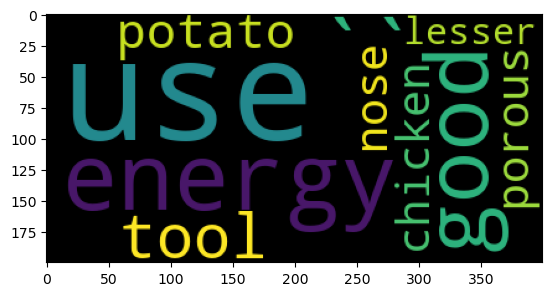

In [14]:
# get frequencies of each cluster's words and create word_clouds

cluster_zero_freqs = {x:freqs[x] for x in cluster_zero_words}
wc_zero = WordCloud().fit_words(cluster_zero_freqs)
plt.imshow(wc_zero)

## BERT Topic Model

In [8]:
## BERT Topic Model

from sklearn.feature_extraction.text import CountVectorizer

# Remove stopwords after documents are assigned to topics
# Allows the transformer model to get the full context of the 
# data, while removing stopwords that are noise in the topics
vectorizer_model = CountVectorizer(stop_words="english")

# Define and train the model
topic_model = BERTopic(nr_topics=2, vectorizer_model=vectorizer_model)
topics, probs = topic_model.fit_transform(docs)
topic_model.get_topic_info() 

,Topic,Count,Name,Representation,Representative_Docs
0,-1,48,-1_use_new_material_pumice,"[use, new, material, pumice, products, used, s...",[Application for removing weed on sidewalks as...
